<h3>Problem Statement</h3>
World Mental Health Day is celebrated on October 10 each year. The ojective of this day is to raise an awareness about mental issues around the world and mobilise efforts in support of mental health. Accoriding to an anonymous survey, about 450 million people live with mental disorders that can be one of the primary causes of poor health and disability worldwide.<br>
<p></p>
<h4>Objective</h4>
You are a machine learning engineer in a company. You are given a task  to understand and bserve th mental health of all the employees in your company. Therefore, you are required to predict the burn out rate of employees based on the provided features thus helping the company to take appropriate measures for their employees.<br>
<p></p>
<span>Evaluation Metric</span>: 100 * R<sup>2</sup> score

<p style="text-align:center; width:80%; font-size:1.2em"><b>Variable Definitions</b></p>
<table style="width:100%; font-size:1.02em">
    <tr>
        <th style="text-align:left">Column Name</th>
        <th style="text-align:left">Description</th></tr>
    <tr>
        <td>Employee ID</td>
        <td>Unique id of the employee</td></tr>
    <tr>
        <td>Date of Joining</td>
        <td>Date on which the employee joined the company</td></tr>
    <tr>
        <td>Gender</td>
        <td>Gender of the Employee</td></tr>
    <tr>   
        <td>Company Type</td>
        <td>Type of company eg Service Based, Product Based etc</td></tr>
    <tr>
        <td>WFH Setup Available</td>
        <td>Whether proper work from home setup is available or not</td></tr>
    <tr>
        <td>Designation</td>
        <td>Seniority level of the employee in codes</td></tr>
    <tr>
        <td>Resource Allocation</td>
        <td>Hours allocated per Day</td></tr>
    <tr>
        <td>Mental Fatigue Score</td>
        <td>Stress rating provided by the employees</td></tr>
    <tr>
        <td>Burn Rate</td>
        <td>Rate of saturation or burn out rate (Target)</td></tr>
</table>

In [1]:
path = "C:/Machine_learning_datafiles/HackerEarth"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import missingno as msno

In [4]:
%matplotlib inline
pd.set_option('display.max_columns', 50)
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size':12})

In [5]:
train = pd.read_csv(path+'/Employee_BurnOut/train.csv', parse_dates=['Date of Joining'])
test = pd.read_csv(path+'/Employee_BurnOut/test.csv', parse_dates=['Date of Joining'])
subfile = pd.read_csv(path+'/Employee_BurnOut/sample_submission.csv')

In [6]:
train.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


In [7]:
test.head(3)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,fffe31003300390039003000,2008-12-10,Female,Service,No,2.0,5.0,7.7
1,fffe31003300310037003800,2008-08-14,Female,Product,Yes,1.0,2.0,5.2
2,fffe33003400380035003900,2008-11-13,Male,Product,Yes,1.0,3.0,5.9


In [8]:
#replacing spaces in column names with '_'
train.columns = train.columns.str.replace('\s', '_', regex=True)
test.columns = test.columns.str.replace('\s', '_', regex=True)

In [9]:
train.shape, test.shape

((22750, 9), (12250, 8))

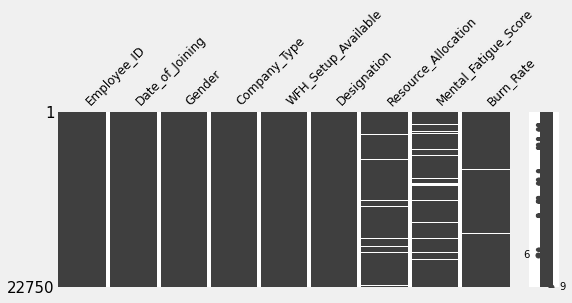

In [10]:
#checking for missing values
msno.matrix(train, fontsize=12, figsize=(8,3));

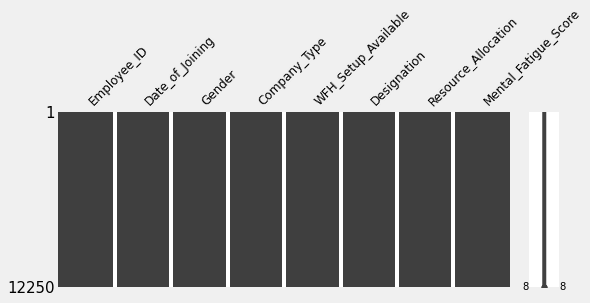

In [11]:
msno.matrix(test, fontsize=12, figsize=(8,3));

The training set contains some missing values. Unfortunately, our target variable contains some too. So we would drop rows where the dependent variable is missing.<br>
While in the test there's no missing values.

In [12]:
train.isna().sum()

Employee_ID                0
Date_of_Joining            0
Gender                     0
Company_Type               0
WFH_Setup_Available        0
Designation                0
Resource_Allocation     1381
Mental_Fatigue_Score    2117
Burn_Rate               1124
dtype: int64

We have about 1124 instances in the Dependent variable that are missing or not recorded.

In [13]:
train = train.dropna(subset=['Burn_Rate']).reset_index(drop=True)

In [14]:
print('After dropping rows in the dependent variable that were missing the training set has {:2d} rows.'.format(
    train.shape[0]))

After dropping rows in the dependent variable that were missing the training set has 21626 rows.


In [15]:
train.isna().sum()[train.isna().sum() > 0]

Resource_Allocation     1278
Mental_Fatigue_Score    1945
dtype: int64

After dropping rows with missing values from the dependent variable, we have no missing values in the dependent variable, but we still have more in the Resource Allocation and Mental Fatigue Score. Looking at the number of missing values before and after removing missing values in the dependent variable, we can see that most of the rows with missing Burn rates actually didn't contain any missing values in these variables.

In [16]:
(2020 - train['Date_of_Joining'].dt.year).unique()

array([12], dtype=int64)

From the dates an employee joined, we see that all employees are employees that were employed in the year 2008- meaning that the maximum year an employee has stayed is 12 years, counting from the current year 2020.
So we want to get the total number of months an employee has stayed. Since if we go by the year they joined, all will have the same year length in service.<br>
So, to get a distinction b/w employees, we would convert 12 years to months to the get the total number of months till now.<br>
To get the actual months, since there are 12 months in a year, we would get the month they joined from the end of the year and then subtract from the total number of months there are in 12 years.

In [17]:
def month_in_service(x):
    """
    Function that returns the length of stay of an employee 
    in the organisation, in months,from the current year 2020
    
    Parameters
    ----------
    x = Date the customer joined
    
    Returns
    -------
    The months in service
    """
    service_in_yrs = 2020 - x.year
    service_in_months = (12 * service_in_yrs) - x.month
    return service_in_months

In [18]:
train['months_in_Service'] = train['Date_of_Joining'].apply(month_in_service)
test['months_in_Service'] = test['Date_of_Joining'].apply(month_in_service)

In [19]:
train.months_in_Service.unique()

array([135, 133, 141, 137, 143, 134, 132, 139, 142, 138, 136, 140],
      dtype=int64)

In [20]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Designation,21626.0,2.178766,1.135428,0.0,1.00,2.00,3.00,5.0
Resource_Allocation,20348.0,4.483831,2.048170,1.0,3.00,4.00,6.00,10.0
Mental_Fatigue_Score,19681.0,5.729851,1.920784,0.0,4.60,5.90,7.10,10.0
Burn_Rate,21626.0,0.452005,0.198226,0.0,0.31,0.45,0.59,1.0
months_in_Service,21626.0,137.490983,3.441459,132.0,135.00,137.00,141.00,143.0


In [21]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Designation,12250.0,2.175265,1.132885,0.0,1.0,2.0,3.0,5.0
Resource_Allocation,12250.0,4.458857,2.045602,1.0,3.0,4.0,6.0,10.0
Mental_Fatigue_Score,12250.0,5.720571,1.914063,0.0,4.5,5.9,7.1,10.0
months_in_Service,12250.0,137.491673,3.469020,132.0,134.0,137.0,141.0,143.0


In [22]:
train.apply(['kurt', 'skew'])

,Designation,Resource_Allocation,Mental_Fatigue_Score,Burn_Rate,months_in_Service
kurt,-0.417219,-0.485710,0.167881,-0.261579,-1.215610
skew,0.089444,0.201922,-0.432639,0.045737,0.015304


In [23]:
test.apply(['kurt', 'skew'])

,Designation,Resource_Allocation,Mental_Fatigue_Score,months_in_Service
kurt,-0.427706,-0.454598,0.134891,-1.240148
skew,0.062401,0.211771,-0.429993,0.012762


Looking at the skewness and kurtosis of the numerical variables, we see that they are almost normally distributed

In [24]:
train.describe(include=['O']).T

,count,unique,top,freq
Employee_ID,21626,21626,fffe31003500320034003500,1
Gender,21626,2,Female,11349
Company_Type,21626,2,Service,14124
WFH_Setup_Available,21626,2,Yes,11685


In [25]:
test.describe(include=['O']).T

,count,unique,top,freq
Employee_ID,12250,12250,fffe33003100350037003100,1
Gender,12250,2,Female,6445
Company_Type,12250,2,Service,8004
WFH_Setup_Available,12250,2,Yes,6638


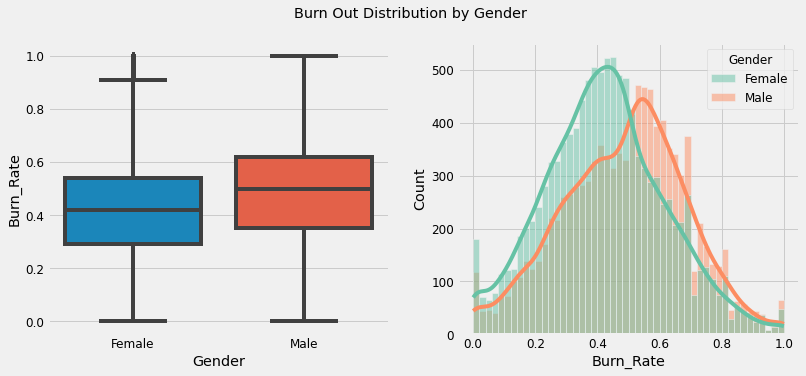

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.boxplot('Gender', 'Burn_Rate', data=train)

plt.subplot(122)
sns.histplot(data=train, x='Burn_Rate', hue='Gender', kde=True, palette='Set2')
plt.suptitle('Burn Out Distribution by Gender');

The Burn Rate for Males is greater than that of Females on average. Some women burn above the 1.5*IQR

In [27]:
print(train.Company_Type.unique())
print(train.WFH_Setup_Available.unique())

['Service' 'Product']
['No' 'Yes']


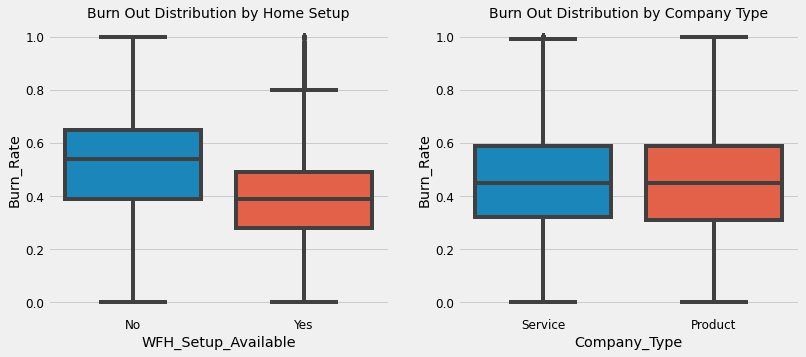

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.boxplot('WFH_Setup_Available', 'Burn_Rate', data=train)
plt.title('Burn Out Distribution by Home Setup', fontsize=14)
plt.subplot(122)
sns.boxplot('Company_Type', 'Burn_Rate', data=train)
plt.title('Burn Out Distribution by Company Type', fontsize=14);

Employees with improper home setups tend to have higher burn rate. This makes sense, because if the conditions an employee is working isn't condusive, they tend to have higher burn out rate, and higher stress.<br>
Conversely, there isn't any difference in Burn Rate across the company type. This implies that burn out rate is the same whether the employee's company type is Service based or Product based.

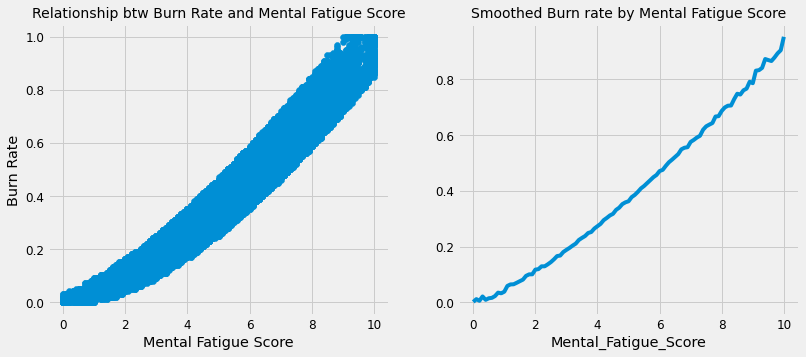

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter('Mental_Fatigue_Score', 'Burn_Rate', data=train)
plt.xlabel('Mental Fatigue Score')
plt.ylabel('Burn Rate')
plt.title('Relationship btw Burn Rate and Mental Fatigue Score', fontsize=14)
plt.subplot(122)
train.groupby('Mental_Fatigue_Score').Burn_Rate.mean().plot()
plt.title('Smoothed Burn rate by Mental Fatigue Score', fontsize=14);

There's a non linear (Exponential) relationship b/w the Mental Fatigue score and Burn Rate

In [30]:
train.head(1)

,Employee_ID,Date_of_Joining,Gender,Company_Type,WFH_Setup_Available,Designation,Resource_Allocation,Mental_Fatigue_Score,Burn_Rate,months_in_Service
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16,135


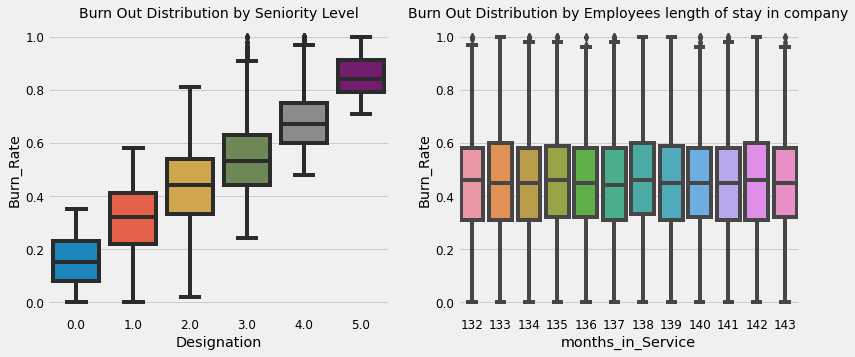

In [31]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.boxplot('Designation', 'Burn_Rate', data=train)
plt.title('Burn Out Distribution by Seniority Level', fontsize=14)
plt.subplot(122)
sns.boxplot('months_in_Service', 'Burn_Rate', data=train)
plt.title('Burn Out Distribution by Employees length of stay in company', fontsize=14);

Wow! Burn level increases across seniority level of employee in the company. Employees in lower designations, have lower burn out rate, while employees in designation 5, have the highest burn out rate.<br>
There is no difference in the length of stay of employees.

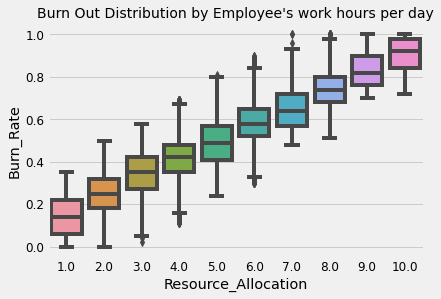

In [32]:
sns.boxplot('Resource_Allocation', 'Burn_Rate', data=train)
plt.title('Burn Out Distribution by Employee\'s work hours per day', fontsize=14);

There's also a difference b/w the burn rate and the hours of work. This makes sense because, the number of hours one works the more tired they become.<br>
Let's see if there's a difference in the Burn Rate for employees across Seniority level and Home Setup

In [33]:
setup_desig = train['Designation'].astype(str) + '__' + train['WFH_Setup_Available']
setup_desig.name = 'Setup_Designates'

In [34]:
train[['Burn_Rate']].join(setup_desig).head()

,Burn_Rate,Setup_Designates
0,0.16,2.0__No
1,0.36,1.0__Yes
2,0.49,2.0__Yes
3,0.20,1.0__Yes
4,0.52,3.0__No


In [35]:
np.sort(setup_desig.unique())

array(['0.0__No', '0.0__Yes', '1.0__No', '1.0__Yes', '2.0__No',
       '2.0__Yes', '3.0__No', '3.0__Yes', '4.0__No', '4.0__Yes',
       '5.0__No', '5.0__Yes'], dtype=object)

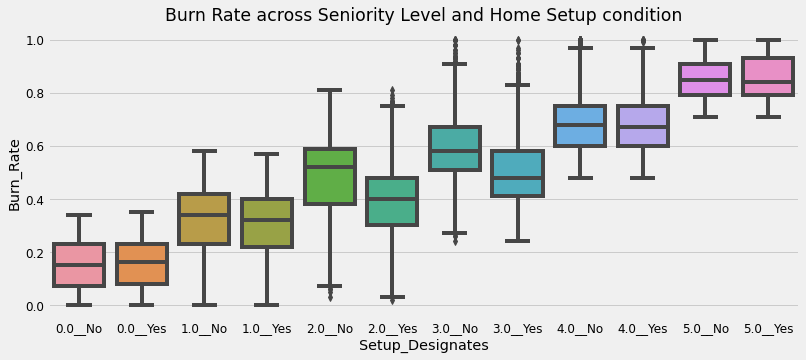

In [36]:
plt.figure(figsize=(12,5))
sns.boxplot(data=train[['Burn_Rate']].join(setup_desig), y='Burn_Rate',x='Setup_Designates', order=np.sort(setup_desig.unique()))
plt.title('Burn Rate across Seniority Level and Home Setup condition');

Just like we saw in the Seniority level, we see similar things here. <hr>
<span>Notes:</span>
1. For employees in Designation 0, the Burn out rate is low, irrespective of the type of Home setup
2. There's a slight difference in Burn rate b/w employees in Designation 1, depending on the type of home setup.
3. Huge difference is seen for employees in Designations 2 and 3- Employees with uncondusive setups at home, have a higher burn rates than employees using condusive setups. Proper care should be taken for employees at those level with poort home setups. <br>
As we have seen, Poor setups incrases Burn out rate, which has a deleterious effect on the productivity of the employee, and the company runs the risj of employee attrition.
4. For Employees in Designations 4 and 5, no matter the type of home setup, there's higher burn out rate. There must be other variables that affect their burn rates. Let's take a look at the Working hours allocated to them.<hr>

In [37]:
train.Resource_Allocation.unique()

array([ 3.,  2., nan,  1.,  7.,  4.,  6.,  5.,  8., 10.,  9.])

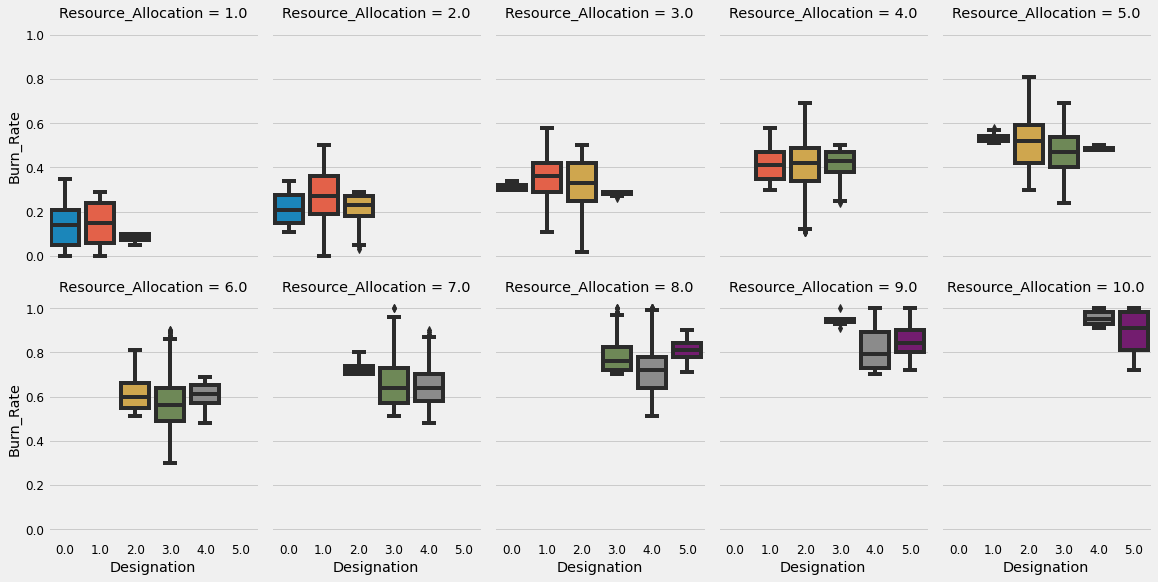

In [38]:
sns.catplot(data=train, y='Burn_Rate',x='Designation', kind='box',  col='Resource_Allocation',
            col_wrap=5, aspect=0.8, height=4,
            order=np.sort(train.Designation.dropna().unique()))
plt.show()

**Resource Allocation is another factor that affects burn rate of employees. Here, we see that as the number of hours of work per day increases, the burn rate of an employee increases. <br>
We see that Employees in Designation 0 work just 3 hours per day max. Employees in Designation 1, work 5 hours max; employees in Designation 2 work 6hours per day. For Employees in other designations, the minimum hours of work per day is 3 hours and above, till 10 hours.<br>
Furthermore, this plot explains why employees in desgination 5 have higher burn rates than other employees in other designations: it is because the minimum number of hours per day of work, for them, is 8hours, till 10hours.**

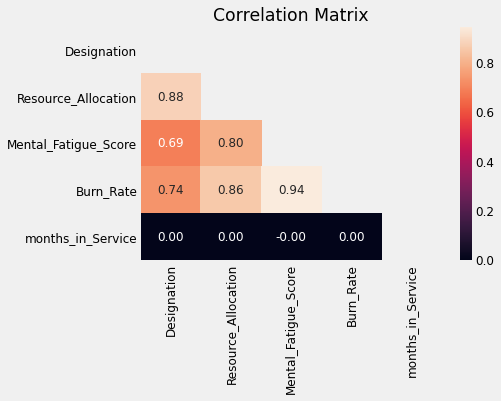

In [39]:
sns.heatmap(train.corr(), annot=True, fmt='.2f', mask=np.triu(train.corr()))
plt.title('Correlation Matrix');

In [40]:
train.shape, test.shape

((21626, 10), (12250, 9))

Filling in missing values

We will be replacing the missing values with their mean values

In [41]:
desig_fatigue = train.groupby(['Designation']).Mental_Fatigue_Score.mean().to_dict()
desig_work_hr = train.groupby('Designation').Resource_Allocation.mean().to_dict()

In [42]:
train.loc[train.Mental_Fatigue_Score.isna(), 'Mental_Fatigue_Score']  = train.loc[
    train.Mental_Fatigue_Score.isna(), 'Designation'].map(desig_fatigue)

train.loc[train.Resource_Allocation.isna(), 'Resource_Allocation']  = train.loc[
    train.Resource_Allocation.isna(), 'Designation'].map(desig_work_hr)

In [43]:
train.isna().sum()

Employee_ID             0
Date_of_Joining         0
Gender                  0
Company_Type            0
WFH_Setup_Available     0
Designation             0
Resource_Allocation     0
Mental_Fatigue_Score    0
Burn_Rate               0
months_in_Service       0
dtype: int64